# DL training: Feature comparison on MLP model

## Setup

In [1]:
import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from fastai.vision.all import *
from katlas.dnn import *

In [2]:
seed_everything()

In [3]:
def_device

'cuda'

## Data

In [4]:
df_t5=pd.read_parquet('train/pspa_t5.parquet').reset_index()
df_esm=pd.read_parquet('train/pspa_esm.parquet').reset_index()
df_onehot = pd.read_parquet('train/pspa_onehot.parquet').reset_index()
df_onehot_pca = pd.read_parquet('train/pspa_onehot_pca.parquet').reset_index()

In [5]:
(df_onehot['index'] == df_esm['index']).value_counts()

index
True    368
Name: count, dtype: int64

In [6]:
(df_t5['index'] == df_esm['index']).value_counts()

index
True    368
Name: count, dtype: int64

In [7]:
t5_col = df_t5.columns[df_t5.columns.str.startswith('T5_')]

In [8]:
t5_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

In [9]:
esm_col = df_esm.columns[df_esm.columns.str.startswith('esm_')]

In [10]:
esm_col

Index(['esm_0', 'esm_1', 'esm_2', 'esm_3', 'esm_4', 'esm_5', 'esm_6', 'esm_7',
       'esm_8', 'esm_9',
       ...
       'esm_1270', 'esm_1271', 'esm_1272', 'esm_1273', 'esm_1274', 'esm_1275',
       'esm_1276', 'esm_1277', 'esm_1278', 'esm_1279'],
      dtype='object', length=1280)

In [11]:
target_col = df_t5.columns[~df_t5.columns.isin(t5_col)][1:]

In [12]:
target_col

Index(['-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P', '4P',
       ...
       '-5pY', '-4pY', '-3pY', '-2pY', '-1pY', '0pY', '1pY', '2pY', '3pY',
       '4pY'],
      dtype='object', length=230)

In [13]:
onehot_col = df_onehot.columns[~df_onehot.columns.isin(target_col)][1:]

In [14]:
onehot_col

Index(['65_-', '65_A', '65_C', '65_D', '65_E', '65_F', '65_G', '65_H', '65_I',
       '65_K',
       ...
       '3192_M', '3192_N', '3192_P', '3192_Q', '3192_R', '3192_S', '3192_T',
       '3192_V', '3192_W', '3192_Y'],
      dtype='object', length=6849)

In [15]:
onehot_pca_col = df_onehot_pca.columns[df_onehot_pca.columns.str.startswith('PCA')]

In [16]:
onehot_pca_col

Index(['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9',
       'PCA10',
       ...
       'PCA991', 'PCA992', 'PCA993', 'PCA994', 'PCA995', 'PCA996', 'PCA997',
       'PCA998', 'PCA999', 'PCA1000'],
      dtype='object', length=1000)

In [17]:
info=Data.get_kinase_info()

info = info[info.pseudo=='0']

info = info[info.kd_ID.notna()]

subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']
family_map = info[['kd_ID','family']].drop_duplicates().set_index('kd_ID')['family']
group_map = info[['kd_ID','group']].drop_duplicates().set_index('kd_ID')['group']

pspa_info = pd.DataFrame(df_t5['index'].tolist(),columns=['kinase'])

pspa_info['subfamily'] = pspa_info.kinase.map(subfamily_map)
pspa_info['family'] = pspa_info.kinase.map(family_map)
pspa_info['group'] = pspa_info.kinase.map(group_map)

## Split

In [18]:
splits = get_splits(pspa_info, group='subfamily',nfold=5)

split0 = splits[0]

GroupKFold(n_splits=5, random_state=None, shuffle=False)
# subfamily in train set: 120
# subfamily in test set: 29


## Dataset

In [19]:
# dataset
ds_t5 = GeneralDataset(df_t5,t5_col,target_col)
ds_esm = GeneralDataset(df_esm,esm_col,target_col)
ds_onehot = GeneralDataset(df_onehot,onehot_col,target_col)
ds_onehot_pca = GeneralDataset(df_onehot_pca,onehot_pca_col,target_col)


In [20]:
len(ds_t5)

368

In [21]:
dl_t5 = DataLoader(ds_t5, batch_size=64, shuffle=True)
dl_esm = DataLoader(ds_esm, batch_size=64, shuffle=True)
dl_onehot = DataLoader(ds_onehot, batch_size=64, shuffle=True)
dl_onehot_pca = DataLoader(ds_onehot_pca, batch_size=64, shuffle=True)


In [22]:
xb,yb = next(iter(dl_t5))

xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 10]))

## Model

In [23]:
n_t5 = len(t5_col)
n_esm = len(esm_col)
n_onehot = len(onehot_col)
n_onehot_pca = len(onehot_pca_col)
n_target = len(target_col)

In [24]:
n_t5,n_esm,n_onehot,n_onehot_pca

(1024, 1280, 6849, 1000)

In [25]:

# def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

def get_mlp_t5(): return PSSM_model(n_t5,n_target,model='MLP')
def get_mlp_esm(): return PSSM_model(n_esm,n_target,model='MLP')
def get_mlp_onehot(): return PSSM_model(n_onehot,n_target,model='MLP')
def get_mlp_onehot_pca(): return PSSM_model(n_onehot_pca,n_target,model='MLP')


In [26]:
model = get_mlp_t5()

In [27]:
logits= model(xb)

In [28]:
logits.shape

torch.Size([64, 23, 10])

## Loss

In [29]:
CE(logits,yb)

tensor(3.2301, grad_fn=<MeanBackward0>)

## Metrics

In [30]:
KLD(logits,yb)

tensor(0.4888, grad_fn=<MeanBackward0>)

In [31]:
JSD(logits,yb)

tensor(0.1021, grad_fn=<MeanBackward0>)

## CV train
> cross-validation

In [32]:
oof_t5 = train_dl_cv(df_t5,t5_col,target_col,
                  splits = splits,
                  model_func = get_mlp_t5,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.148606,3.121804,0.402347,0.085257,00:00
1,3.072263,3.087032,0.367574,0.081199,00:00
2,3.009716,3.024146,0.304688,0.072146,00:00
3,2.956377,2.943933,0.224475,0.056424,00:00
4,2.916552,2.875516,0.156058,0.040018,00:00
5,2.888994,2.847860,0.128402,0.031854,00:00
6,2.868063,2.812665,0.093207,0.022109,00:00
7,2.851901,2.805371,0.085913,0.020331,00:00
8,2.839283,2.805355,0.085897,0.020335,00:00
9,2.829078,2.798256,0.078798,0.018366,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.138617,3.128191,0.373281,0.080388,00:00
1,3.052587,3.099994,0.345084,0.076962,00:00
2,2.987546,3.036049,0.281140,0.067385,00:00
3,2.936046,2.949912,0.195002,0.050177,00:00
4,2.899863,2.884509,0.129600,0.033173,00:00
5,2.874496,2.846201,0.091292,0.022750,00:00
6,2.855753,2.834026,0.079116,0.019371,00:00
7,2.840722,2.826782,0.071872,0.017719,00:00
8,2.828521,2.834439,0.079530,0.019417,00:00
9,2.819003,2.826963,0.072054,0.017538,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.132746,3.129335,0.376952,0.081733,00:00
1,3.044635,3.098221,0.345837,0.077880,00:00
2,2.977475,3.029599,0.277215,0.067289,00:00
3,2.928447,2.946265,0.193881,0.049801,00:00
4,2.894571,2.878941,0.126558,0.031526,00:00
5,2.870487,2.854545,0.102161,0.024659,00:00
6,2.851943,2.844638,0.092254,0.021932,00:00
7,2.837645,2.839031,0.086647,0.020559,00:00
8,2.826392,2.835832,0.083448,0.019848,00:00
9,2.817550,2.839705,0.087322,0.020473,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.133904,3.137529,0.374512,0.080143,00:00
1,3.051439,3.116435,0.353418,0.077698,00:00
2,2.983982,3.059940,0.296923,0.069758,00:00
3,2.933919,2.971472,0.208456,0.052888,00:00
4,2.897793,2.900559,0.137543,0.035083,00:00
5,2.873204,2.871643,0.108627,0.026768,00:00
6,2.854192,2.859234,0.096217,0.023959,00:00
7,2.838984,2.853621,0.090605,0.021992,00:00
8,2.827404,2.853444,0.090427,0.021758,00:00
9,2.817780,2.850291,0.087274,0.021522,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.125827,3.126822,0.377269,0.081392,00:00
1,3.043140,3.096131,0.346577,0.077685,00:00
2,2.979392,3.034656,0.285102,0.068493,00:00
3,2.931132,2.957115,0.207562,0.052795,00:00
4,2.896671,2.893782,0.144228,0.036598,00:00
5,2.872172,2.861912,0.112359,0.027619,00:00
6,2.854473,2.847451,0.097898,0.023141,00:00
7,2.840559,2.843453,0.093899,0.022363,00:00
8,2.829472,2.845010,0.095456,0.022714,00:00
9,2.820066,2.836954,0.087400,0.020894,00:00


In [33]:
oof_esm = train_dl_cv(df_esm,esm_col,target_col,
                  splits = splits,
                  model_func = get_mlp_esm,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.170443,3.128315,0.408857,0.086049,00:00
1,3.091747,3.074181,0.354723,0.079727,00:00
2,3.024167,2.957788,0.238329,0.059704,00:00
3,2.968613,2.866479,0.147021,0.037654,00:00
4,2.926947,2.807119,0.087661,0.020968,00:00
5,2.896099,2.801955,0.082497,0.019621,00:00
6,2.873465,2.799124,0.079666,0.018746,00:00
7,2.856784,2.796772,0.077314,0.018224,00:00
8,2.843669,2.794605,0.075147,0.017636,00:00
9,2.833229,2.799318,0.079859,0.018553,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.122061,3.125437,0.370527,0.079903,00:00
1,3.039709,3.077375,0.322466,0.073699,00:00
2,2.981365,2.966509,0.211600,0.053809,00:00
3,2.933924,2.868390,0.113481,0.029373,00:00
4,2.898599,2.839211,0.084302,0.020951,00:00
5,2.873605,2.834185,0.079276,0.019625,00:00
6,2.855162,2.833194,0.078285,0.018720,00:00
7,2.840910,2.828449,0.073540,0.017761,00:00
8,2.829222,2.824754,0.069845,0.016848,00:00
9,2.819603,2.827720,0.072810,0.017521,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.131628,3.128202,0.375819,0.081358,00:00
1,3.046990,3.089172,0.336788,0.076419,00:00
2,2.980138,2.984057,0.231674,0.058168,00:00
3,2.931372,2.893255,0.140872,0.035893,00:00
4,2.896703,2.848695,0.096311,0.023613,00:00
5,2.872715,2.847809,0.095425,0.022987,00:00
6,2.854965,2.840352,0.087968,0.021104,00:00
7,2.841479,2.841226,0.088842,0.021400,00:00
8,2.829988,2.839816,0.087432,0.020786,00:00
9,2.820873,2.840088,0.087704,0.020787,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.120882,3.127987,0.364970,0.079264,00:00
1,3.036895,3.088904,0.325887,0.074284,00:00
2,2.972838,2.992755,0.229738,0.057605,00:00
3,2.926071,2.886852,0.123836,0.031949,00:00
4,2.892499,2.848272,0.085255,0.020823,00:00
5,2.870296,2.847814,0.084798,0.020389,00:00
6,2.853154,2.849026,0.086010,0.020700,00:00
7,2.839834,2.847083,0.084066,0.020318,-1:59:59
8,2.828994,2.844793,0.081776,0.019672,00:00
9,2.819419,2.842653,0.079636,0.019257,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.133451,3.130460,0.380906,0.081534,00:00
1,3.053220,3.090420,0.340867,0.076725,00:00
2,2.989331,2.990456,0.240902,0.060124,00:00
3,2.940887,2.895016,0.145463,0.037410,00:00
4,2.905284,2.854676,0.105123,0.025265,00:00
5,2.879787,2.847856,0.098302,0.023136,00:01
6,2.860288,2.840653,0.091100,0.021613,00:00
7,2.845451,2.835020,0.085466,0.020448,00:00
8,2.833287,2.837122,0.087568,0.020906,00:00
9,2.824138,2.845146,0.095592,0.022325,00:00


In [34]:
oof_onehot = train_dl_cv(df_onehot,onehot_col,target_col,
                  splits = splits,
                  model_func = get_mlp_onehot,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.107481,3.079334,0.359876,0.080672,00:00
1,3.024266,2.912568,0.193110,0.048698,00:00
2,2.961029,2.823816,0.104358,0.026342,00:00
3,2.913608,2.798980,0.079521,0.019046,00:00
4,2.879827,2.794405,0.074947,0.017684,00:00
5,2.855628,2.792629,0.073171,0.017242,00:00
6,2.837858,2.791636,0.072178,0.017052,00:00
7,2.824691,2.795679,0.076221,0.017815,00:00
8,2.814432,2.790493,0.071035,0.016618,00:00
9,2.806232,2.789299,0.069841,0.016276,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.105893,3.100944,0.346035,0.077511,00:00
1,3.014429,2.962021,0.207112,0.052557,00:00
2,2.950377,2.859910,0.105000,0.026838,00:00
3,2.902731,2.833114,0.078204,0.019364,00:00
4,2.869296,2.823380,0.068471,0.016776,00:00
5,2.846127,2.823797,0.068887,0.016775,00:00
6,2.828729,2.825376,0.070467,0.017084,00:00
7,2.815908,2.820808,0.065898,0.015970,00:00
8,2.805543,2.821366,0.066457,0.016000,00:00
9,2.797379,2.821266,0.066356,0.015913,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.088713,3.107045,0.354661,0.078924,00:00
1,3.003663,2.985674,0.233290,0.057648,00:00
2,2.941490,2.883777,0.131393,0.032687,00:00
3,2.897114,2.852958,0.100574,0.024289,00:00
4,2.864851,2.847725,0.095341,0.022589,00:00
5,2.842869,2.844643,0.092260,0.021997,00:00
6,2.826611,2.845072,0.092688,0.021976,00:00
7,2.813991,2.847180,0.094796,0.022378,00:00
8,2.804400,2.841731,0.089347,0.021196,00:00
9,2.796265,2.840563,0.088179,0.020948,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.096087,3.110922,0.347905,0.077215,00:00
1,3.005267,2.995671,0.232655,0.057557,00:00
2,2.944075,2.882715,0.119698,0.030261,00:00
3,2.899745,2.851894,0.088877,0.021891,00:00
4,2.867660,2.845201,0.082184,0.019869,00:00
5,2.844286,2.842517,0.079500,0.019032,00:00
6,2.827374,2.840275,0.077259,0.018516,00:00
7,2.814086,2.840380,0.077364,0.018408,00:00
8,2.803528,2.838695,0.075679,0.018048,00:00
9,2.794903,2.840422,0.077406,0.018451,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.100043,3.093074,0.343521,0.077535,00:00
1,3.013312,2.967172,0.217618,0.053456,00:00
2,2.951631,2.892219,0.142666,0.035091,00:00
3,2.903811,2.850470,0.100917,0.024567,00:00
4,2.870965,2.840093,0.090540,0.021754,00:00
5,2.847079,2.836390,0.086837,0.020592,00:00
6,2.830200,2.832452,0.082898,0.019636,00:00
7,2.817096,2.833317,0.083763,0.019721,00:00
8,2.806404,2.832405,0.082851,0.019474,00:00
9,2.798034,2.832736,0.083183,0.019539,00:00


In [35]:
oof_onehot_pca = train_dl_cv(df_onehot_pca,onehot_pca_col,target_col,
                  splits = splits,
                  model_func = get_mlp_onehot_pca,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.189602,3.113463,0.394005,0.084773,00:00
1,3.104172,2.977305,0.257847,0.062730,00:00
2,3.021253,2.857183,0.137725,0.035252,00:00
3,2.958511,2.821630,0.102172,0.025253,00:00
4,2.914731,2.809329,0.089871,0.021631,00:00
5,2.883622,2.808552,0.089094,0.021433,00:00
6,2.860193,2.807707,0.088249,0.021026,00:00
7,2.842225,2.802818,0.083360,0.019840,00:00
8,2.828530,2.801093,0.081635,0.019522,00:00
9,2.817219,2.799792,0.080334,0.019123,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.182634,3.119604,0.364695,0.079957,00:00
1,3.094388,3.023017,0.268108,0.064864,00:00
2,3.009603,2.895565,0.140655,0.037207,00:00
3,2.945920,2.855029,0.100119,0.025731,00:00
4,2.902055,2.841548,0.086639,0.021765,00:00
5,2.870601,2.840891,0.085981,0.021420,00:00
6,2.847384,2.835758,0.080849,0.019897,00:00
7,2.830473,2.836553,0.081643,0.020070,00:00
8,2.816775,2.834080,0.079170,0.019415,00:00
9,2.806609,2.833592,0.078683,0.019308,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.180655,3.133078,0.380694,0.082307,00:00
1,3.087744,3.049715,0.297332,0.070353,00:00
2,3.001378,2.914612,0.162228,0.041429,00:00
3,2.940427,2.872758,0.120375,0.030020,00:00
4,2.897774,2.859895,0.107511,0.026098,00:00
5,2.867156,2.863013,0.110629,0.026861,00:00
6,2.844925,2.856844,0.104461,0.025312,00:00
7,2.828006,2.852781,0.100397,0.024134,00:00
8,2.815066,2.853749,0.101365,0.024317,00:00
9,2.804623,2.853329,0.100945,0.024254,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.171948,3.122044,0.359027,0.078739,00:00
1,3.078477,3.038632,0.275615,0.066434,00:00
2,2.995987,2.918788,0.155771,0.040377,00:00
3,2.935148,2.868035,0.105018,0.026499,00:00
4,2.893677,2.856677,0.093661,0.023154,00:00
5,2.863889,2.860430,0.097414,0.023751,00:00
6,2.841698,2.854681,0.091664,0.022408,00:00
7,2.825094,2.852442,0.089426,0.021593,00:00
8,2.812347,2.851212,0.088195,0.021338,00:00
9,2.802684,2.850125,0.087109,0.020951,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.168980,3.113049,0.363495,0.080159,00:00
1,3.080419,3.011974,0.262420,0.064262,00:00
2,2.998897,2.907214,0.157660,0.039925,00:00
3,2.938524,2.865003,0.115449,0.028375,00:00
4,2.896167,2.856457,0.106903,0.026023,00:00
5,2.866137,2.853608,0.104054,0.025234,00:00
6,2.844121,2.851347,0.101793,0.024680,00:00
7,2.827480,2.847170,0.097616,0.023724,00:00
8,2.815023,2.844982,0.095428,0.023147,00:00
9,2.804815,2.843091,0.093538,0.022543,00:00


## Score

In [36]:
from katlas.pssm import *

from functools import partial

In [37]:
def score_df(target,pred,func):
    distance = [func(target.loc[i],pred.loc[i,target.columns]) for i in target.index]
    return pd.Series(distance,index=target.index)

In [38]:
jsd_df = partial(score_df,func=js_divergence_flat)
jss_df = partial(score_df,func=js_similarity_flat)

kld_df = partial(score_df,func=kl_divergence_flat)

In [39]:
target=df_t5[target_col].copy()

In [40]:
(oof_t5.nfold == oof_esm.nfold).value_counts()

nfold
True    368
Name: count, dtype: int64

In [41]:
pspa_info['split'] = oof_t5.nfold

In [51]:
pspa_info['t5'] =jsd_df(target,oof_t5)
pspa_info['esm'] =jsd_df(target,oof_esm)
pspa_info['onehot'] =jsd_df(target,oof_onehot)
pspa_info['onehot_pca'] =jsd_df(target,oof_onehot_pca)

In [52]:
from katlas.plot import *

In [53]:
set_sns()

In [57]:
pspa_info.to_parquet('raw/MLP_feature_compare_subfamily.parquet')

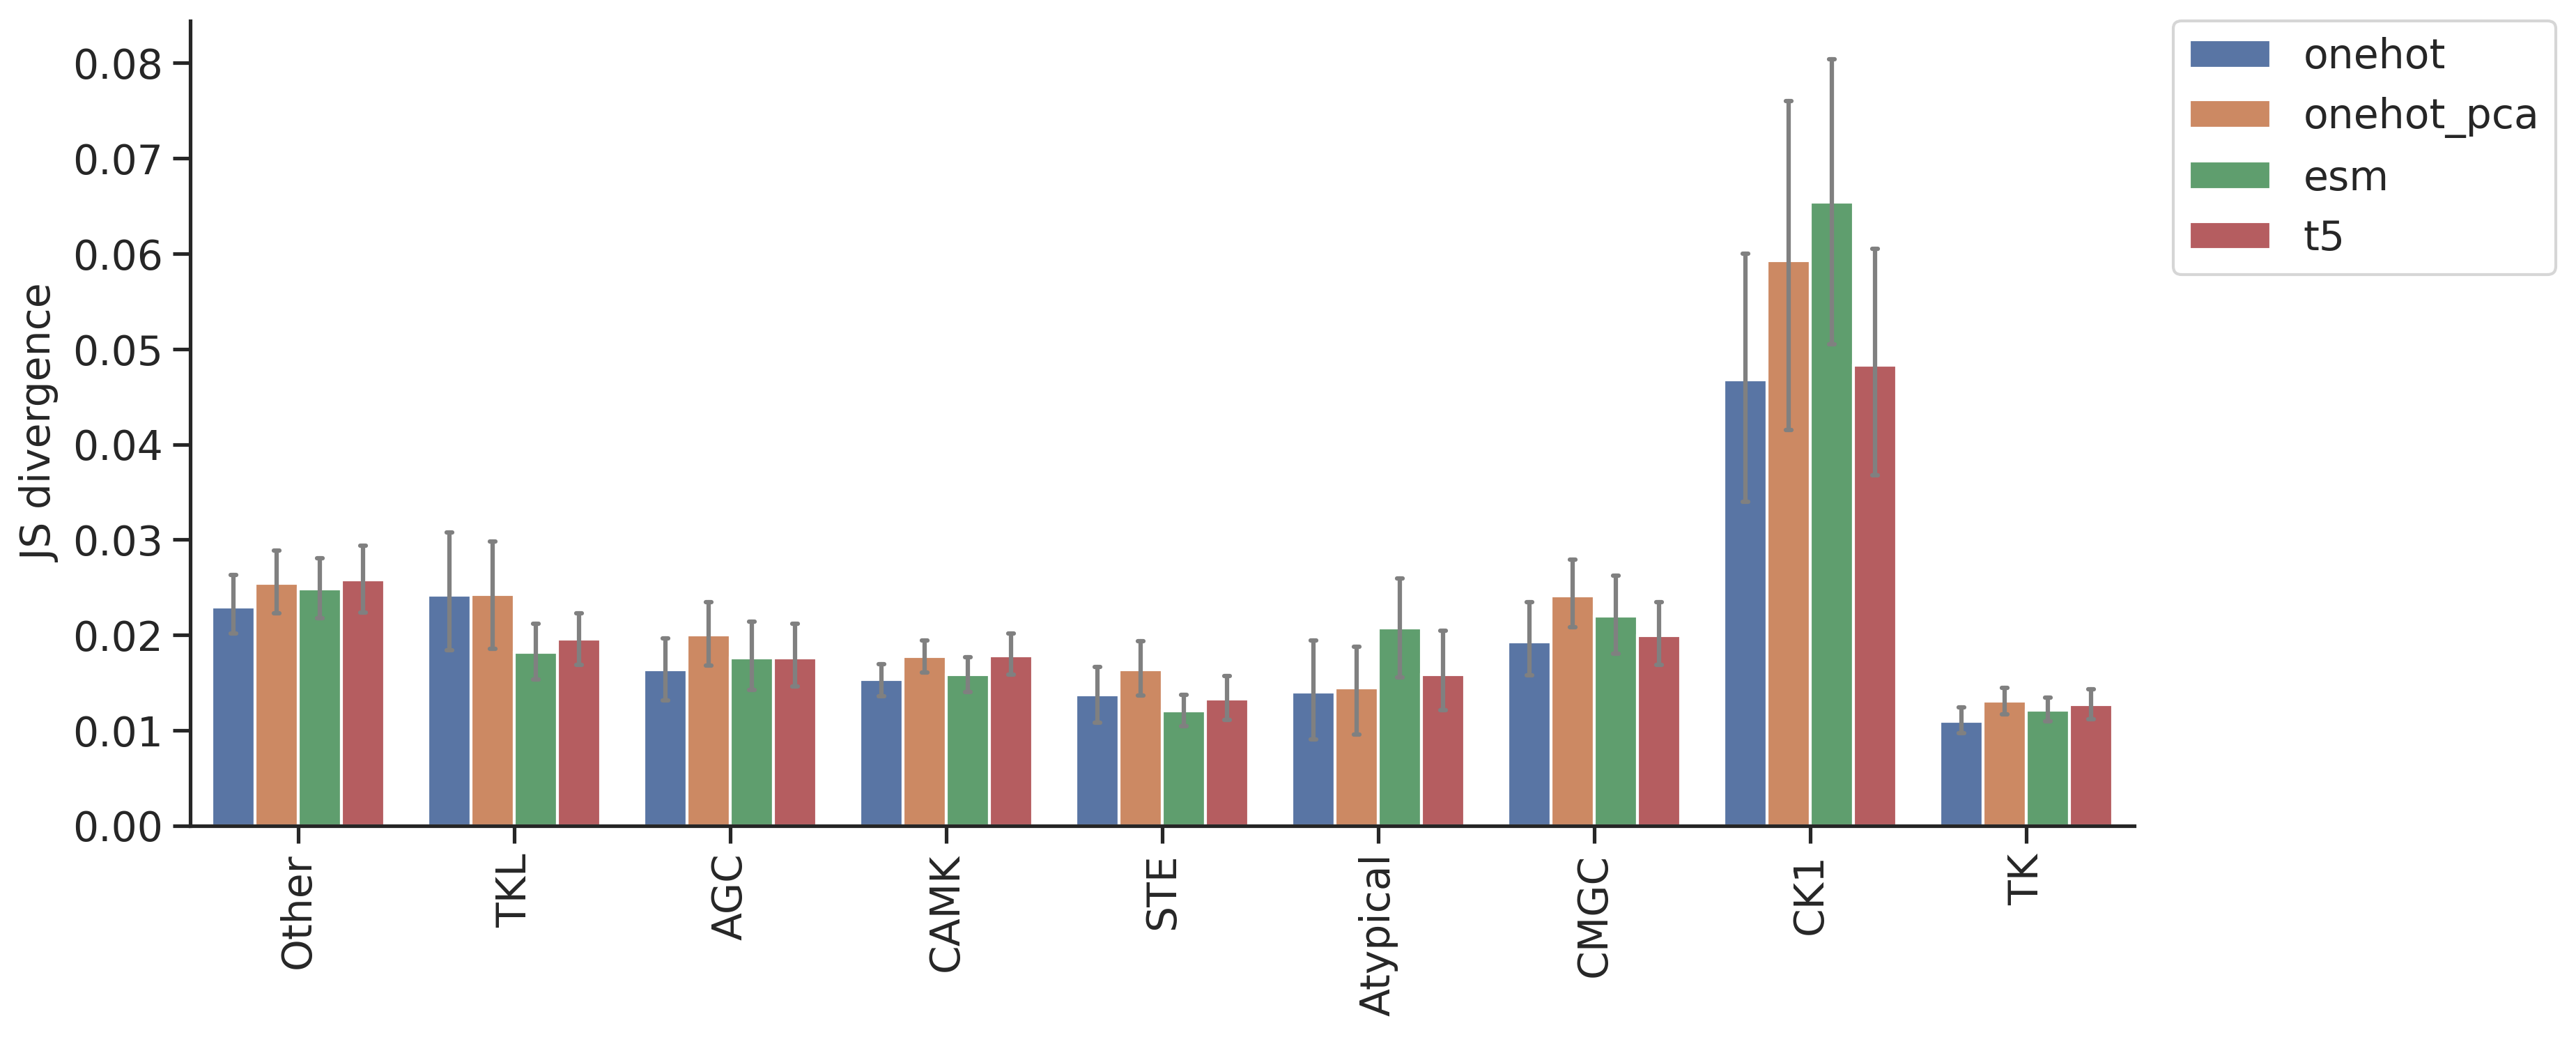

In [58]:
plot_group_bar(pspa_info,['onehot','onehot_pca','esm','t5',],group='group')
plt.ylabel('JS divergence')
save_svg('fig/MLP_feature_comparison.svg')

### For JS similarity (less differentiated)

In [47]:
pspa_info['t5'] =jss_df(target,oof_t5)
pspa_info['esm'] =jss_df(target,oof_esm)
pspa_info['onehot'] =jss_df(target,oof_onehot)
pspa_info['onehot_pca'] =jss_df(target,oof_onehot_pca)

Text(0, 0.5, 'JS divergence')

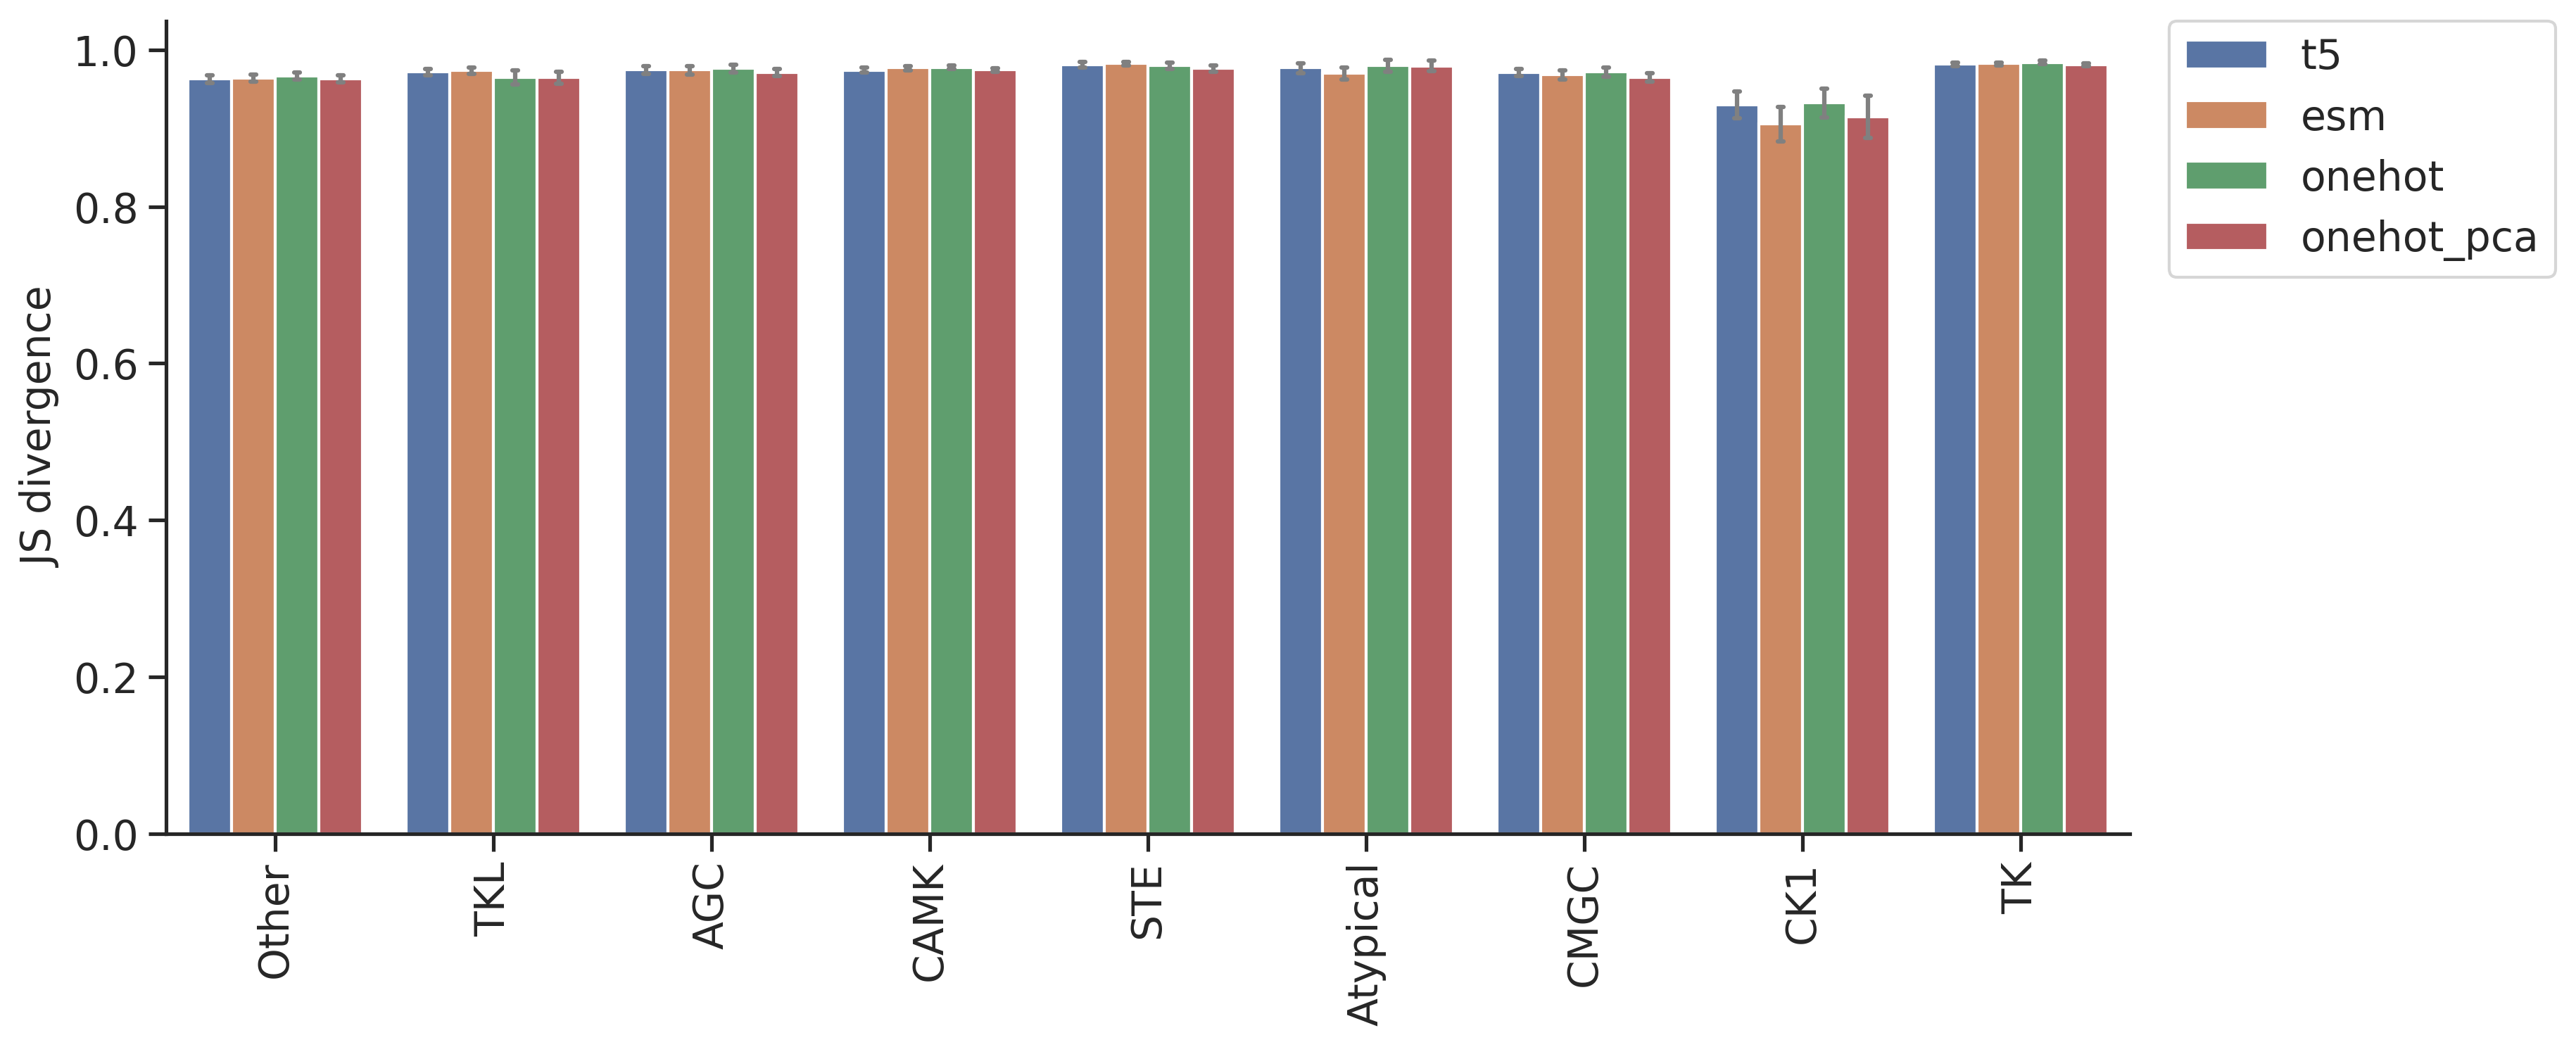

In [48]:
plot_group_bar(pspa_info,['t5','esm','onehot','onehot_pca'],group='group')
plt.ylabel('JS divergence')